# **Stock Price Prediction**

[*********************100%***********************]  1 of 1 completed


RMSE (INR): 15.93


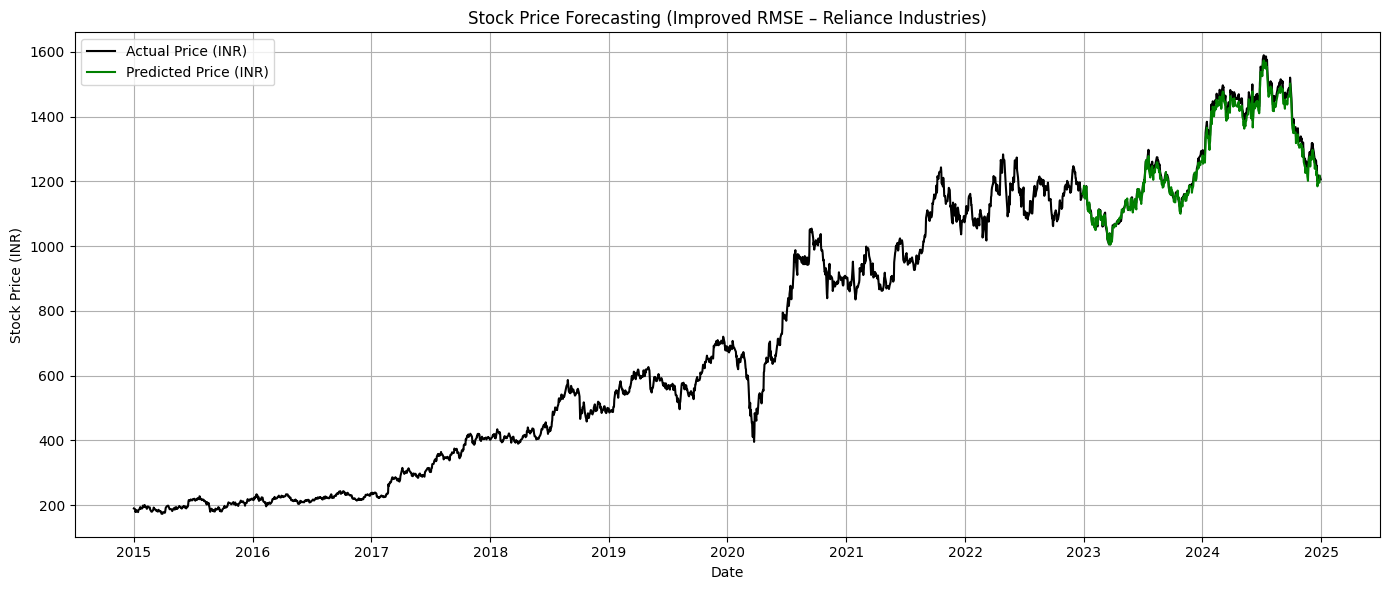

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

ticker = "RELIANCE.NS"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
df = df[['Close']].dropna()

def create_features(data, lags=10):
    df_feat = data.copy()
    
    df_feat["delta_1"] = df_feat["Close"].diff()
    df_feat["ma_5"] = df_feat["Close"].rolling(5).mean()
    df_feat["ma_10"] = df_feat["Close"].rolling(10).mean()
    df_feat["std_10"] = df_feat["Close"].rolling(10).std()
    
    for i in range(1, lags + 1):
        df_feat[f"lag_{i}"] = df_feat["Close"].shift(i)
    
    df_feat["target_delta"] = df_feat["Close"].shift(-1) - df_feat["Close"]
    df_feat.dropna(inplace=True)
    return df_feat

df_feat = create_features(df, lags=10)

X = df_feat.drop(["Close", "target_delta", "delta_1"], axis=1)
y = df_feat["target_delta"]

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

delta_preds = model.predict(X_test)

base_prices = df.loc[X_test.index, "Close"].values.reshape(-1)
price_preds = base_prices + delta_preds

rmse = math.sqrt(mean_squared_error(df.loc[X_test.index, "Close"].values, price_preds))
print("RMSE (INR):", round(rmse, 2))

plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Actual Price (INR)", color="black")
plt.plot(X_test.index, price_preds, label="Predicted Price (INR)", color="green")
plt.title("Stock Price Forecasting (Improved RMSE – Reliance Industries)")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
real_prices = df.loc[X_test.index, "Close"].values.reshape(-1)
pred_prices = price_preds.reshape(-1)

last_n = min(10, len(real_prices))

results = pd.DataFrame({
    "Date": X_test.index[-last_n:],
    "Real Price (INR)": real_prices[-last_n:],
    "Predicted Price (INR)": pred_prices[-last_n:]
})

print("\nLast 10 Real vs Predicted Stock Prices (INR):\n")
print(results.reset_index(drop=True))


Last 10 Real vs Predicted Stock Prices (INR):

        Date  Real Price (INR)  Predicted Price (INR)
0 2024-12-13       1267.786621            1248.843433
1 2024-12-16       1263.254761            1243.835169
2 2024-12-17       1240.346191            1218.355627
3 2024-12-18       1248.264526            1229.939228
4 2024-12-19       1225.555176            1205.029957
5 2024-12-20       1200.505371            1184.483183
6 2024-12-23       1217.437744            1201.772924
7 2024-12-24       1217.885864            1204.370497
8 2024-12-26       1211.710571            1195.573689
9 2024-12-27       1216.192749            1217.014586
